# Autoencoder with Fashion-MNIST Dataset

### Hardware Check

In [1]:
def get_hardware_info(use_in_notebook=True, install_packages=True):
    import platform
    system_name = platform.system()

    if install_packages:
        if system_name.lower() == "windows":
            %pip install psutil    # or: conda install psutil
            %pip install gputil
            %pip install py-cpuinfo
        elif system_name.lower() == "linux":
            !pip install psutil    # or: conda install psutil
            !pip install gputil
            !pip install py-cpuinfo

    # import needed packages
    import psutil
    import GPUtil
    from cpuinfo import get_cpu_info

    if use_in_notebook:
        if install_packages:
            if system_name.lower() == "windows":
                %pip install ipython
            elif system_name.lower() == "linux":
                !pip install ipython

        from IPython.display import clear_output
        clear_output()

    print("-"*32, "\nYour Hardware:\n")

    # General
    print("    ---> General <---")
    print("Operatingsystem:", platform.system())
    print("Version:", platform.version())
    print("Architecture:", platform.architecture())
    print("Processor:", platform.processor())

    # GPU-Information
    print("\n    ---> GPU <---")
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print("GPU Name:", gpu.name)
        print("VRAM Total:", gpu.memoryTotal, "MB")
        print("VRAM Used:", gpu.memoryUsed, "MB")
        print("Utilization:", gpu.load * 100, "%")

    # CPU-Information
    print("\n    ---> CPU <---")
    cpu_info = get_cpu_info()
    print("CPU-Name:", cpu_info["brand_raw"])
    print("CPU Kernels:", psutil.cpu_count(logical=False))
    print("Logical CPU-Kernels:", psutil.cpu_count(logical=True))
    print("CPU-Frequence:", psutil.cpu_freq().max, "MHz")
    print("CPU-Utilization:", psutil.cpu_percent(interval=1), "%")

    # RAM-Information
    print("\n    ---> RAM <---")
    ram = psutil.virtual_memory()
    print("RAM Total:", ram.total // (1024**3), "GB")
    print("RAM Available:", ram.available // (1024**3), "GB")
    print("RAM-Utilization:", ram.percent, "%")

    print(f"\n{'-'*32}")


get_hardware_info(use_in_notebook=True, install_packages=True)

-------------------------------- 
Your Hardware:

    ---> General <---
Operatingsystem: Linux
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Architecture: ('64bit', 'ELF')
Processor: x86_64

    ---> GPU <---
GPU Name: Tesla T4
VRAM Total: 15360.0 MB
VRAM Used: 0.0 MB
Utilization: 0.0 %

    ---> CPU <---
CPU-Name: Intel(R) Xeon(R) CPU @ 2.30GHz
CPU Kernels: 1
Logical CPU-Kernels: 2
CPU-Frequence: 0.0 MHz
CPU-Utilization: 35.9 %

    ---> RAM <---
RAM Total: 12 GB
RAM Available: 11 GB
RAM-Utilization: 9.1 %

--------------------------------


### Imports

In [116]:
import numpy as np
import matplotlib.pyplot as plt
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}''")

from tensorflow.keras import datasets
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

Using 'seaborn-v0_8''


### Data Loading

The **Fashion-MNIST** dataset consists of 28x28 grayimages with a pixel value range from 0-255.

In [4]:
(X_train, y_test), (X_test, y_test) = datasets.fashion_mnist.load_data()

def preprocess(images):
    images = images.astype("float32")/255.0
    images = np.pad(images, ((0,0), (2,2), (2,2)), constant_values=0.0)
    images = np.expand_dims(images, -1)    # np.reshape(-1, 32, 32, 1)
    return images

print(f"\n{X_train.shape}")

X_train = preprocess(X_train)
X_test = preprocess(X_test)

X_train.shape


(60000, 28, 28)


(60000, 32, 32, 1)

### Build the Model

Conv2DTranspose are equal to the Conv2D but the stride defines here how much padding should be applied between each datapoint.

In [11]:
# encoder
encoder_input = layers.Input(shape=(32,32,1), name="eoncoder_input")

x = layers.Conv2D(32, (3,3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3,3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)

# decoder
decoder_input = layers.Input(shape=(2, ), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)    # reshaping from a vector to an tensor

x = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same", activation="relu")(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    padding="same",
    activation="sigmoid",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)

# build autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))


In [13]:
encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ eoncoder_input (InputLayer)          │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
decoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ eoncoder_input (InputLayer)          │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           4,098 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 32, 32, 1)           │         246,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

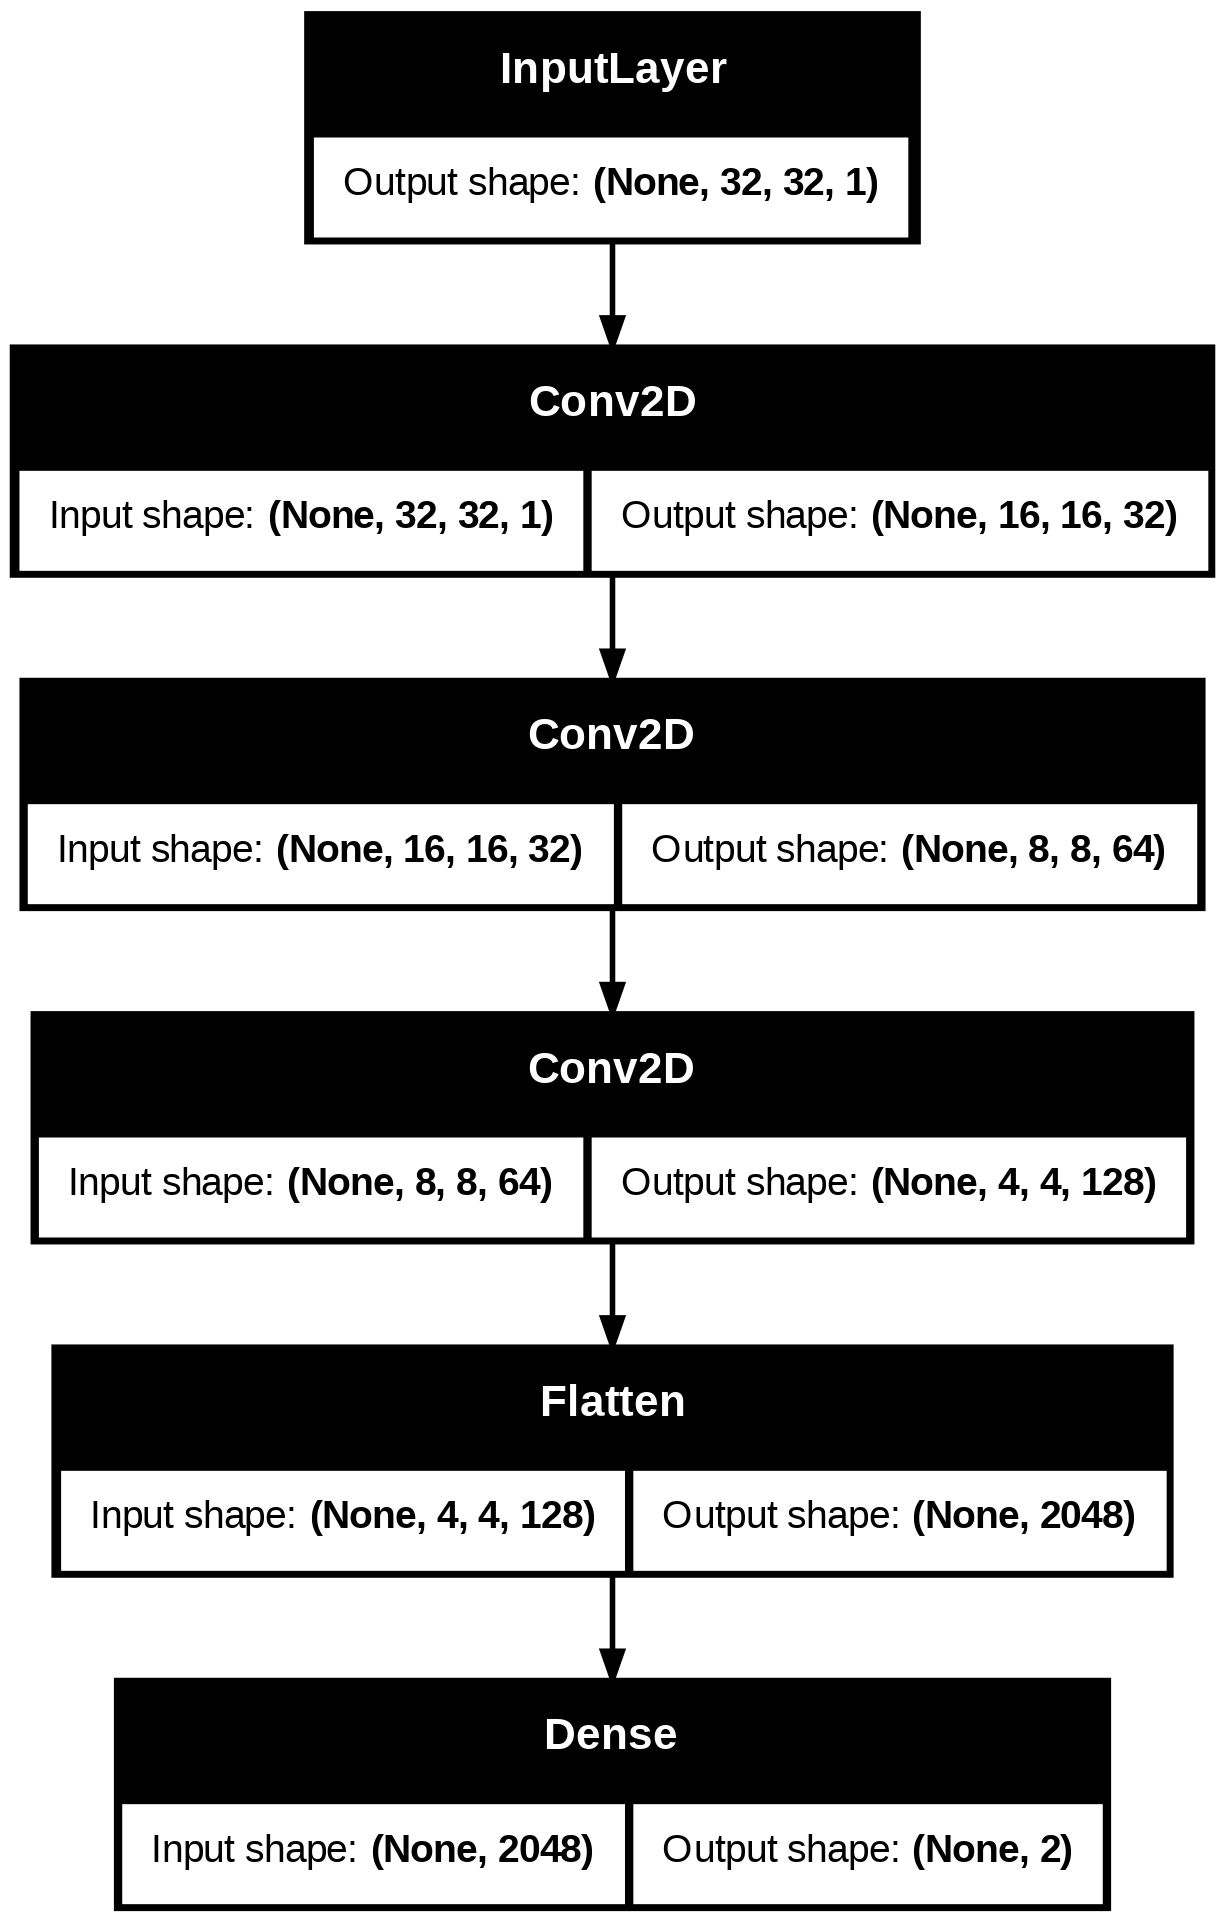

In [23]:
plot_model(encoder, show_shapes=True)

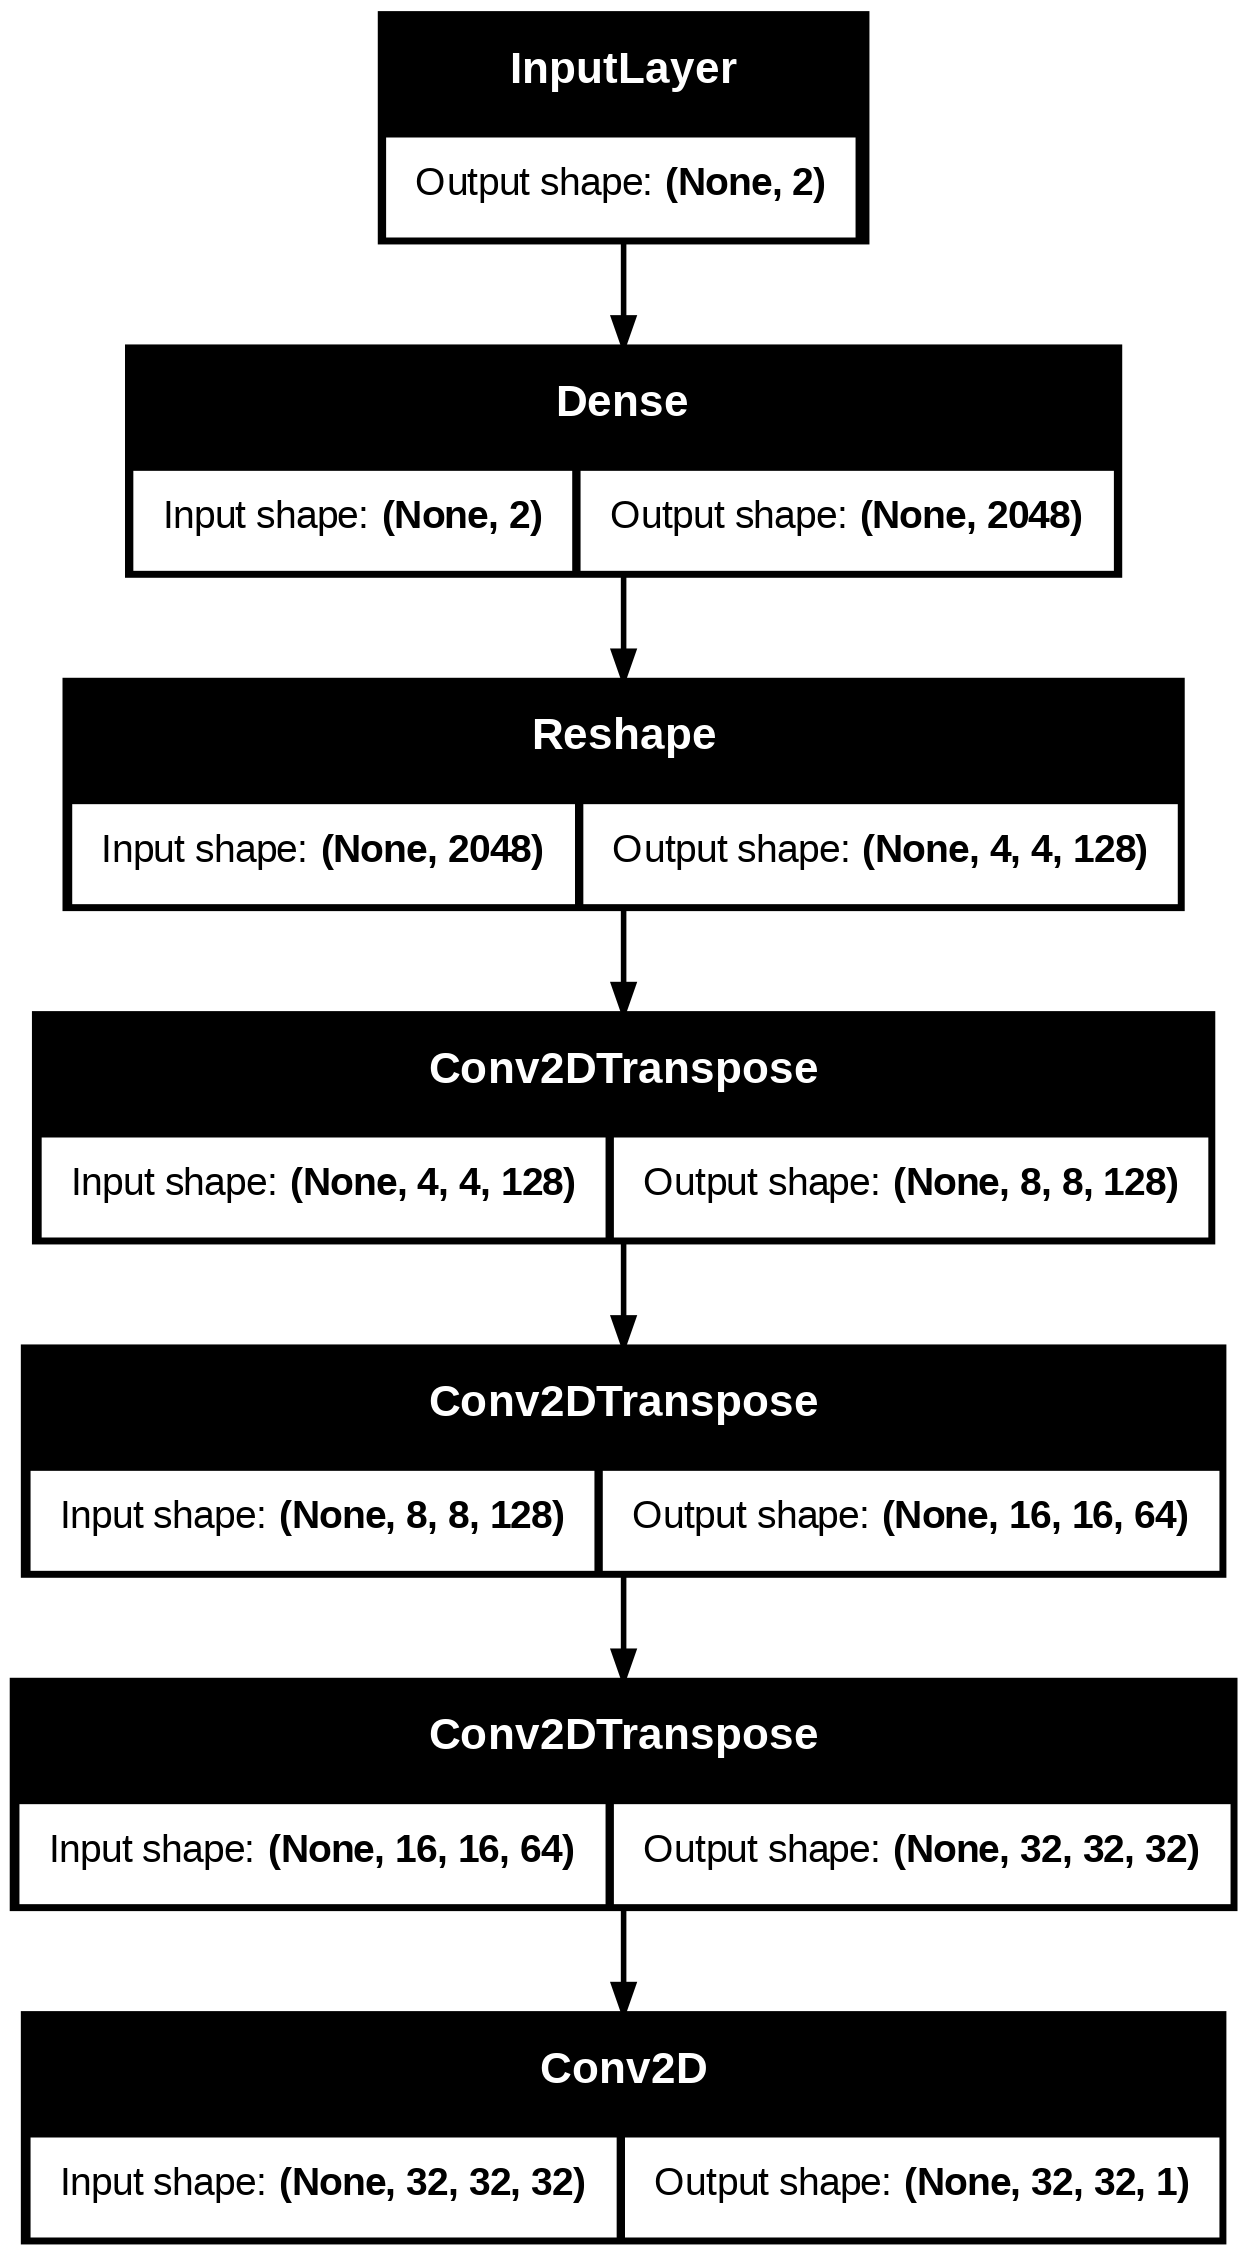

In [20]:
plot_model(decoder, show_shapes=True)

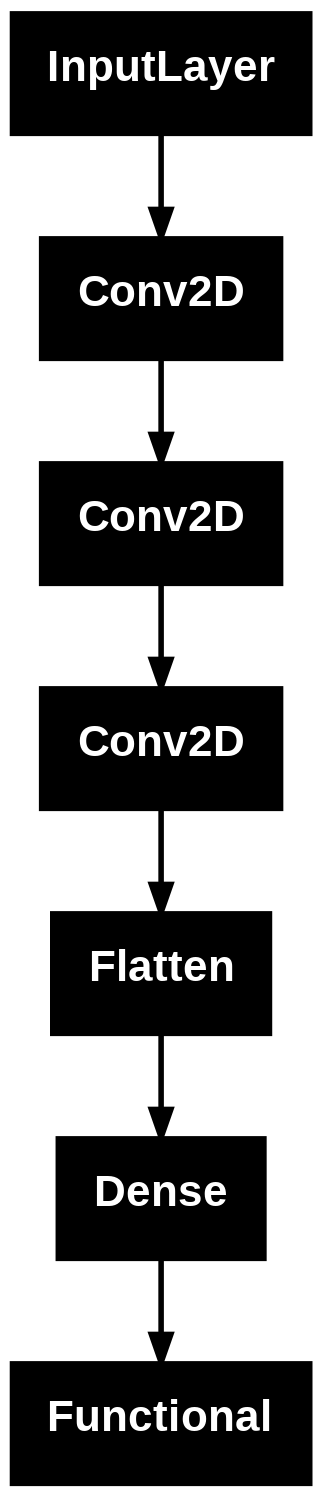

In [22]:
plot_model(autoencoder)

### Compile and train the model

In [25]:
autoencoder.compile(
    optimizer="adam",
    loss="binary_crossentropy"
)

autoencoder.fit(
    X_train,
    X_train,
    epochs=5,
    batch_size=150,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.3890 - val_loss: 0.2697
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2665 - val_loss: 0.2628
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2595 - val_loss: 0.2578
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2565 - val_loss: 0.2560
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2547 - val_loss: 0.2550


### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


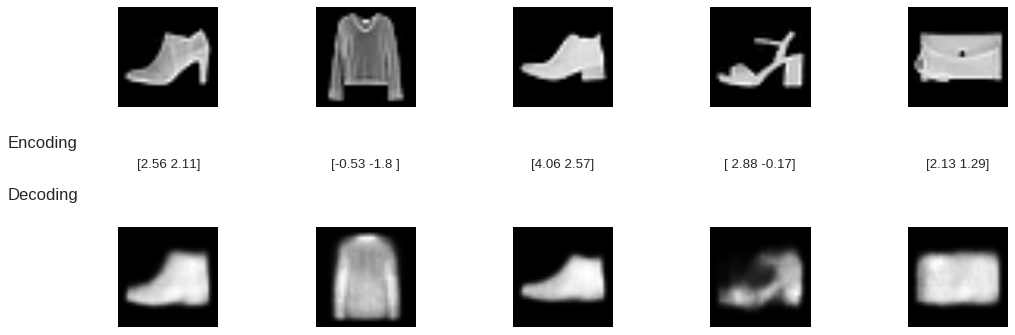

In [117]:
images_to_show = 5
image_idxs = np.random.choice(range(len(X_test)), images_to_show)

images = X_test[image_idxs]
embeddings = encoder.predict(X_test[image_idxs])
reconstructions = decoder.predict(embeddings)

rows = 2
cols = images_to_show // 1 + (images_to_show % 1 > 0)

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5))
fig.subplots_adjust(hspace=1.2, wspace=0.4)

for i, (image, embedding, reconstruction) in enumerate(zip(images, embeddings, reconstructions)):
    ax[0,i].axis('off')
    ax[0,i].text(0.5, -0.6, f"{np.round(embedding, 2)}", fontsize=12, ha='center', transform=ax[0,i].transAxes)
    ax[0,i].imshow(image, cmap="gray")

    # # Add arrow
    # ax[0,i].annotate(
    #     '', xy=(16, 30), xytext=(16, 32),
    #     arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->')
    # )

    ax[1,i].axis('off')
    ax[1,i].imshow(reconstruction, cmap="gray")

fig.text(0.05, 0.55, "Encoding", fontsize=15)
fig.text(0.05, 0.42, "Decoding", fontsize=15)

plt.show();

Visualize Latent Space

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


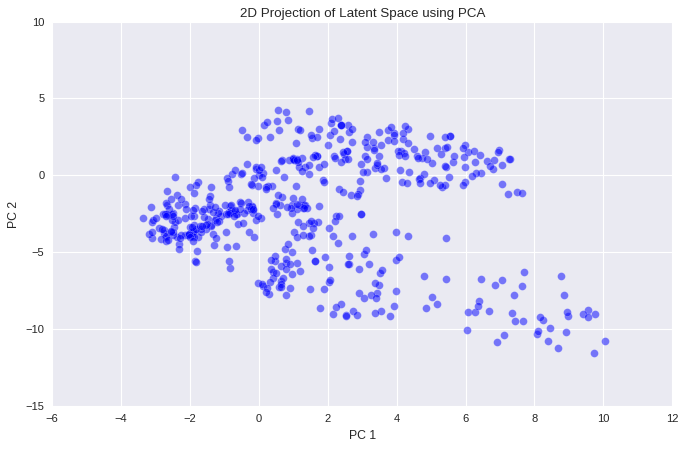

In [125]:
from sklearn.decomposition import PCA

images_to_show = 500
image_idxs = np.random.choice(range(len(X_test)), images_to_show)

images = X_test[image_idxs]
embeddings = encoder.predict(X_test[image_idxs])
reconstructions = decoder.predict(embeddings)

# using dimension reduction to reduce the latent space
if embeddings.shape[-1] > 2:
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', s=50, alpha=0.5)
plt.title("2D Projection of Latent Space using PCA")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


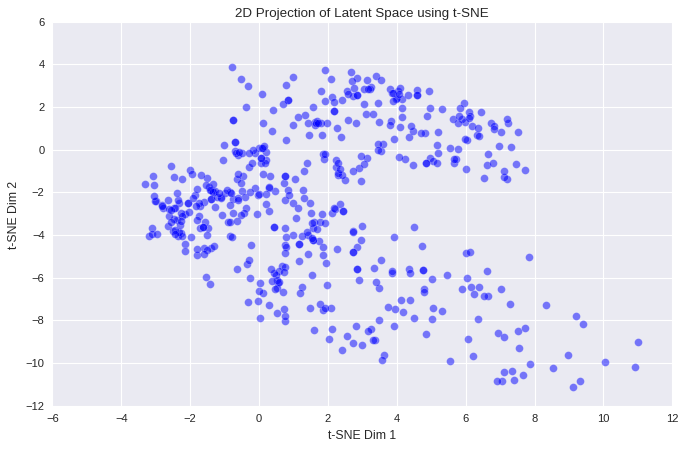

In [126]:
from sklearn.manifold import TSNE

images_to_show = 500
image_idxs = np.random.choice(range(len(X_test)), images_to_show)

images = X_test[image_idxs]
embeddings = encoder.predict(X_test[image_idxs])
reconstructions = decoder.predict(embeddings)

# using dimension reduction to reduce the latent space
if embeddings.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', s=50, alpha=0.5)
plt.title("2D Projection of Latent Space using t-SNE")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

Add labels

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


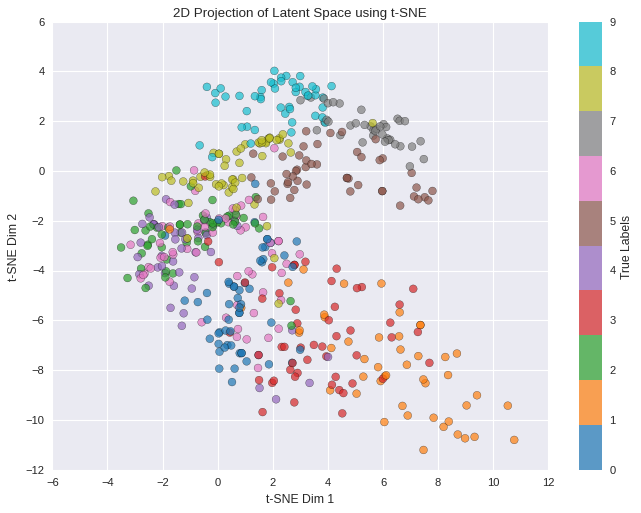

In [129]:
from sklearn.manifold import TSNE

images_to_show = 500
image_idxs = np.random.choice(range(len(X_test)), images_to_show)

images = X_test[image_idxs]
labels = y_test[image_idxs]

embeddings = encoder.predict(X_test[image_idxs])
reconstructions = decoder.predict(embeddings)

# using dimension reduction to reduce the latent space
if embeddings.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                        c=labels, cmap='tab10', alpha=0.7,
                        edgecolors='k', s=50)
plt.colorbar(scatter, label="True Labels")
plt.title("2D Projection of Latent Space using t-SNE")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

Displaying Original, Embedding and Latent Space representation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


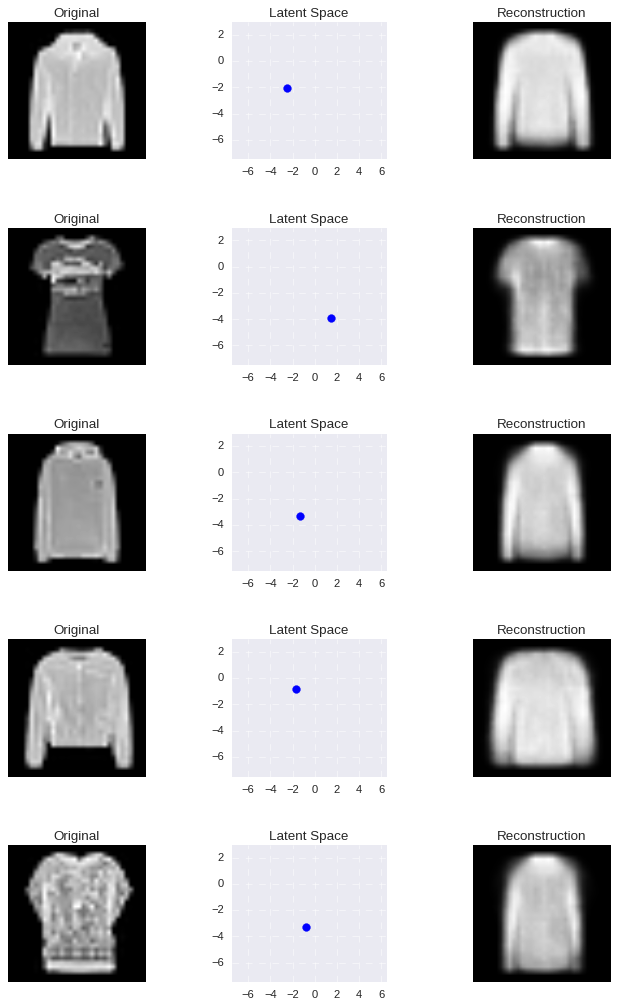

In [131]:
from sklearn.manifold import TSNE

images_to_show = 5
image_idxs = np.random.choice(range(len(X_test)), images_to_show)

images = X_test[image_idxs]
embeddings = encoder.predict(X_test[image_idxs])
reconstructions = decoder.predict(embeddings)

# using dimension reduction to reduce the latent space
if embeddings.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    embeddings = tsne.fit_transform(embeddings)

x_lim = (np.min(embeddings[:, 0])-5, np.max(embeddings[:, 0])+5)
y_lim = (np.min(embeddings[0, :])-5, np.max(embeddings[0, :])+5)

rows = images_to_show
cols = 3  # Original, embedding visualization, reconstruction

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 3 * images_to_show))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, (image, embedding, reconstruction) in enumerate(zip(images, embeddings, reconstructions)):
    # Original Image
    ax[i, 0].imshow(image.squeeze(), cmap='gray')
    ax[i, 0].set_title("Original")
    ax[i, 0].axis('off')

    # Latent Space Representation (First Two Components)
    ax[i, 1].scatter(embedding[0], embedding[1], color='blue', s=50)
    ax[i, 1].set_xlim(x_lim[0], x_lim[1])
    ax[i, 1].set_ylim(y_lim[0], y_lim[1])
    ax[i, 1].set_title("Latent Space")
    ax[i, 1].grid(True, linestyle='--', alpha=0.5)

    # Reconstructed Image
    ax[i, 2].imshow(reconstruction.squeeze(), cmap='gray')
    ax[i, 2].set_title("Reconstruction")
    ax[i, 2].axis('off')

plt.show()

Interpolating the latent space and visualize the decoding

-> this helps to understand the latent space and how the decoder uses it

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


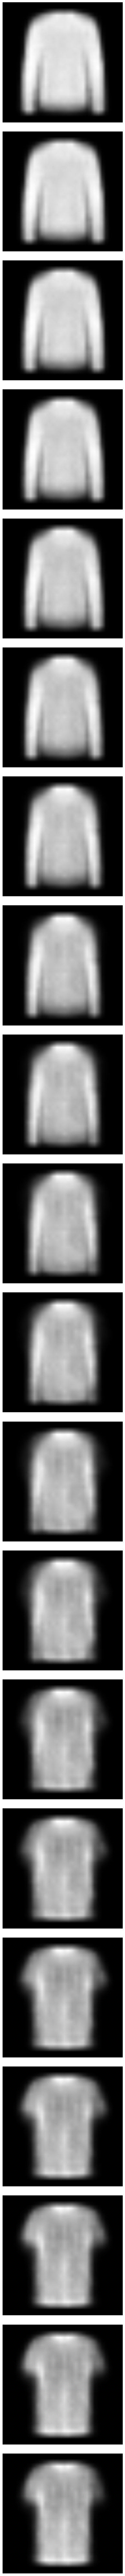

In [140]:
images = X_test[image_idxs]
embeddings = encoder.predict(X_test[image_idxs])

n_interpolations = 20
alpha_values = np.linspace(0, 1, num=n_interpolations)
interpolated_images = []

for alpha in alpha_values:
    interp_embedding = (1 - alpha) * embeddings[0] + alpha * embeddings[1]
    interp_image = decoder.predict(interp_embedding.reshape(1, -1))
    interpolated_images.append(interp_image.squeeze())

fig, axes = plt.subplots(len(alpha_values), 1, figsize=(5, 5*len(alpha_values)))
for i, img in enumerate(interpolated_images):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.tight_layout()
plt.show()

### Generation of new Images

min, max explained:

```python
# np.min/max(..., axis=0) results in the min/max for both/all dimensions -> x and y in this latent-space and np.random.uniform accept multiple values in regard to the shape -> we also create 2 dims samples so 2 random min/max values are fine.
# example:
embedding => [[-2, 9.3], [5.3, -1.2], ...]
np.min(...) = [-5.3, -4.6], np.max(...) = [10.1, 11.2]
np.random.uniform([-5.3, -4.6], [10.1, 11.2], size=(n_samples, 2)) => [[-5.3 to 10.1, -4.6 to 11.2], [-5.3 to 10.1, -4.6 to 11.2], ...]
```

Why min/max? Our latent-space is only valid for the area where we trained observations. So it limits the sample-space where we draw the samples from. For the rest of the rest of the space should be the same or not helpful content.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


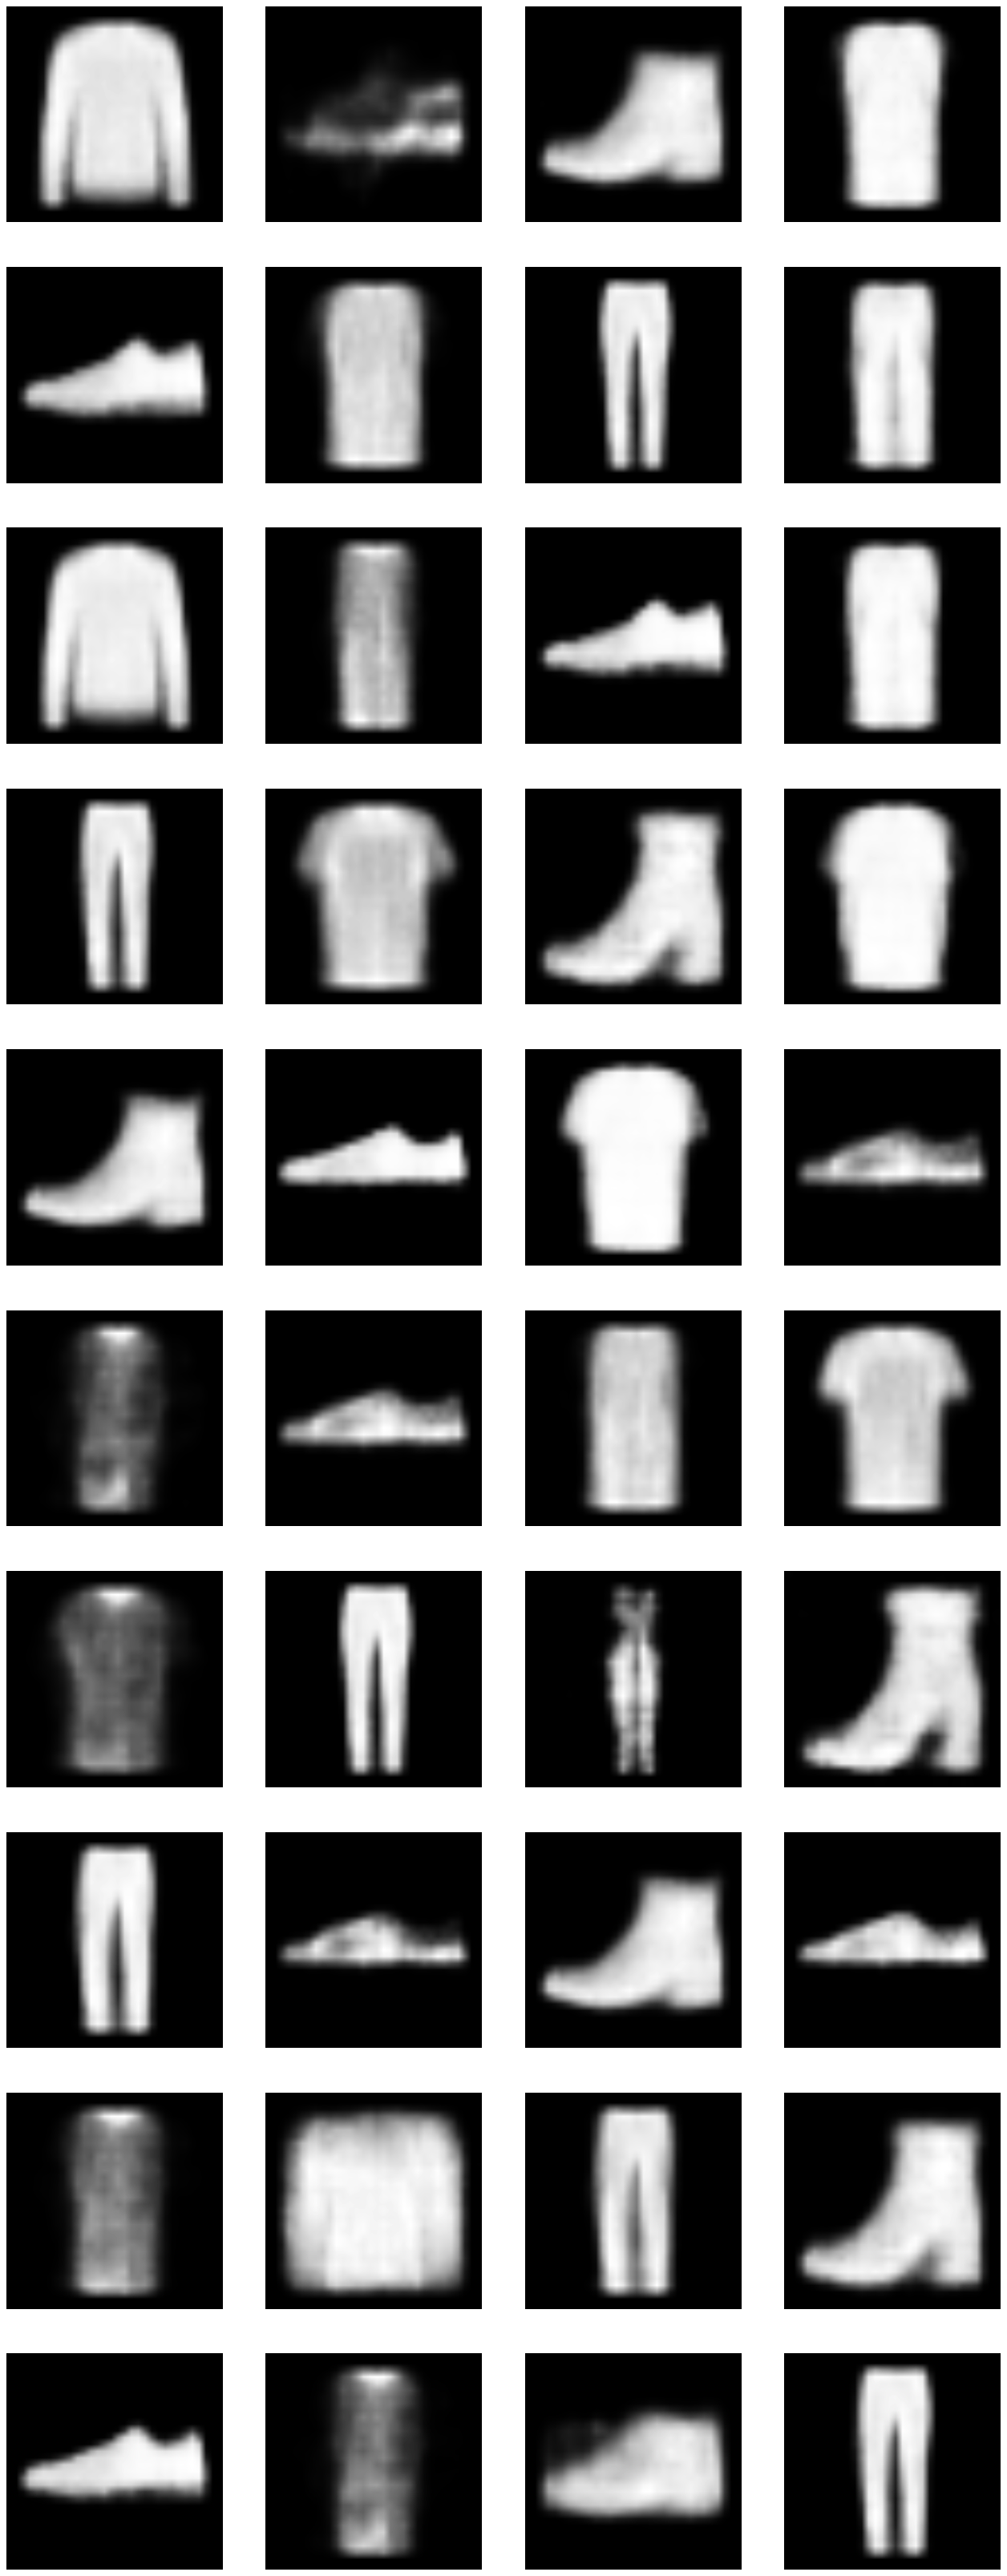

In [160]:
embeddings = encoder.predict(X_test)

mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
n_samples = 40
sample = np.random.uniform(mins, maxs, size=(n_samples, 2))
reconstructions = decoder.predict(sample)

# visualization of new images
rows = 10
cols = len(reconstructions)//rows + int(len(reconstructions) % rows > 0)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 5*rows))
ax = np.ravel(ax)

for idx in range(len(ax)):
    if idx < len(reconstructions):
        ax[idx].imshow(reconstructions[idx], cmap="gray")
    ax[idx].axis('off')